# First pass at new raster tutorial material


### Note: This notebook will focus on accessing Landsat8 and Sentinel2 public datasets on AWS (10-30m postings)

Target area for Cyclone Kenneth 2019-04-25
(building off https://github.com/shaystrong/sagely, https://medium.com/@shay.strong/openstreetmap-data-to-ml-training-labels-for-object-detection-ce0a3ccdb907, https://github.com/shaystrong/sagely/blob/master/osm_ml_training_pt1.ipynb) 

Goals identified by Friederich:
- pull in open source raster data on the fly for the specified bounding box, at a resolution sufficient to delineate buildings
- learn how to explore the data using rasterio and gdal etc.
- groom and clean - ready for ML (could be as simple as changing the projection and dropping unnecessary bands, for example)
- if open raster data sources aren’t at a high enough resolution - good discussion point - can stage a dataset that is. this would also teach folks how to add in their own data and coregister it into the same coordinate system and projection.


bbox = [43.16, -11.32, 43.54, -11.96]

In [3]:
import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

import geopandas as gpd

import satsearch
from satstac import Items

import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv

import ipywidgets
import datetime

from ipywidgets import interact
from IPython.display import display, Image

import json
from cartopy import crs as ccrs

import rasterio
import rasterio.mask
from rasterio.session import AWSSession
import xarray as xr

# Might still be some issues with jupyterlab 1
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [4]:
bbox = [43.16, -11.32, 43.54, -11.96]
west, north, east, south = bbox
bbox_ctr = [0.5*(north+south), 0.5*(west+east)]

## 1) Look at a leaflet slippy map to get accustomed to area of interest

In [5]:
m = Map(center=bbox_ctr, zoom=6)
rectangle = Rectangle(bounds=((south, west), (north, east))) #SW and NE corners of the rectangle (lat, lon)
m.add_layer(rectangle)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## 2) NASA GIBS provides free imagery tiles that can be easily displayed with ipyleaflet

The NASA Worldview web application is a way to explore all GIBS datasets https://worldview.earthdata.nasa.gov/
More here: https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs

NOTES: 
* add some information about MODIS. Coarse resolution, not optimal for building detection, but daily and free!
* also, odds are there are clouds obstructing your view of earth's surface!
* GIBS has pre-rendered images good for visualizations, if you're interested in analytic values for scientific analysis, this isn't the best option
* Apparently the tiles only exist to a zoom level 9 (b/c very coarse resolution)

In [6]:
m = Map(center=bbox_ctr, zoom=8)# MODIS great for large areas (onl)

right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2019-06-30")
left_layer = TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)

m.add_layer(rectangle)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [7]:
# Putting it all together

date_picker = ipywidgets.DatePicker(description='MODIS Image Date: ', value=datetime.datetime.today(), style=dict(description_width='initial'))
m = Map(center=bbox_ctr, zoom=8)# MODIS great for large areas (onl)

right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, )
left_layer = TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)

m.add_layer(rectangle)

def on_value_change(change):
    newurl = f'https://gibs.earthdata.nasa.gov/wmts/epsg3857/best/MODIS_Terra_CorrectedReflectance_TrueColor/default/{date}/GoogleMapsCompatible_Level9/{{z}}/{{y}}/{{x}}.jpg'
    right_layer.set_trait('url', newurl)

date_picker.observe(on_value_change)

display(date_picker, m)

DatePicker(value=datetime.datetime(2019, 8, 21, 5, 42, 52, 430502), description='MODIS Image Date: ', style=De…

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## 3) Sat-search is a tool to discover free imagery on AWS 

https://github.com/sat-utils/sat-search
https://github.com/sat-utils/sat-stac

https://github.com/pangeo-data/intake-stac

https://registry.opendata.aws/
    
    
NOTES: 
* bbox and coordinate listing often have different orderings (lon, lat) (south, north, west, east)
* add a table comparing Landsat8, Sentinel2, CBERS (resolution/posting, repeat interval)

In [53]:
# bbox as a python list is great for use in python, but we can instead save to a more interoperable format (GeoJSON)
# Here is a great website for creating and visualizing geojson on a map: http://geojson.io


aoi = { "type": "Polygon", 
    "coordinates": [[[west, south], [west, north], [east, north], [east, south], [west, south]]]
}
# pretty print formatting
print(json.dumps(aoi, sort_keys=False, indent=2))

# save to file for future use
with open('aoi-5977.geojson', 'w') as f:
    json.dump(aoi, f)

{
  "type": "Polygon",
  "coordinates": [
    [
      [
        43.16,
        -11.96
      ],
      [
        43.16,
        -11.32
      ],
      [
        43.54,
        -11.32
      ],
      [
        43.54,
        -11.96
      ],
      [
        43.16,
        -11.96
      ]
    ]
  ]
}


In [54]:

# Load results to pandas geodataframe
# now other packages such as geojson can read this file
gfa = gpd.read_file('aoi-5977.geojson')
gfa

geometry
0  POLYGON ((43.16 -11.96, 43.16 -11.32, 43.54 -1...

In [55]:
# Sat-search provides an intuitive way to search for images using STAC catalogs (https://stacspec.org/)


results = satsearch.Search(bbox=bbox, datetime='2019-02-01/2019-06-01')
print('%s items' % results.found())
items = results.items()
print('%s collections:' % len(items._collections))
print(items._collections)


137 items
2 collections:
[landsat-8-l1, sentinel-2-l1c]


In [56]:
# If you are unfamiliar with one of these satellites, we can look at stored metadata
col = items._collections[0]

print('Title:', col.title)
print('Collection Version:', col.version)
print('Keywords: ', col.keywords)
print('License:', col.license)
print('Providers:', col.providers)
print('Extent', col.extent)

Title: Landsat 8 L1
Collection Version: 0.1.0
Keywords:  ['landsat', 'earth observation', 'usgs']
License: PDDL-1.0
Providers: [{'name': 'USGS', 'roles': ['producer'], 'url': 'https://landsat.usgs.gov/'}, {'name': 'Planet Labs', 'roles': ['processor'], 'url': 'https://github.com/landsat-pds/landsat_ingestor'}, {'name': 'AWS', 'roles': ['host'], 'url': 'https://landsatonaws.com/'}, {'name': 'Development Seed', 'roles': ['processor'], 'url': 'https://github.com/sat-utils/sat-api'}]
Extent {'spatial': [-180, -90, 180, 90], 'temporal': ['2013-06-01', None]}


In [57]:
# We can delve deeper to see what kind of metadata is available at the scene level
for key in col.properties:
    if key == 'eo:bands':
        [print(band) for band in col[key]]
    else:
        print('%s: %s' % (key, col[key]))

collection: landsat-8-l1
eo:gsd: 15
eo:platform: landsat-8
eo:instrument: OLI_TIRS
eo:off_nadir: 0
{'name': 'B1', 'common_name': 'coastal', 'gsd': 30, 'center_wavelength': 0.44, 'full_width_half_max': 0.02}
{'name': 'B2', 'common_name': 'blue', 'gsd': 30, 'center_wavelength': 0.48, 'full_width_half_max': 0.06}
{'name': 'B3', 'common_name': 'green', 'gsd': 30, 'center_wavelength': 0.56, 'full_width_half_max': 0.06}
{'name': 'B4', 'common_name': 'red', 'gsd': 30, 'center_wavelength': 0.65, 'full_width_half_max': 0.04}
{'name': 'B5', 'common_name': 'nir', 'gsd': 30, 'center_wavelength': 0.86, 'full_width_half_max': 0.03}
{'name': 'B6', 'common_name': 'swir16', 'gsd': 30, 'center_wavelength': 1.6, 'full_width_half_max': 0.08}
{'name': 'B7', 'common_name': 'swir22', 'gsd': 30, 'center_wavelength': 2.2, 'full_width_half_max': 0.2}
{'name': 'B8', 'common_name': 'pan', 'gsd': 15, 'center_wavelength': 0.59, 'full_width_half_max': 0.18}
{'name': 'B9', 'common_name': 'cirrus', 'gsd': 30, 'center_

In [58]:
# How does Sentinel-2 data differ?
col = items._collections[1]
print('Title:', col.title)
print('Collection Version:', col.version)
print('Keywords: ', col.keywords)
print('License:', col.license)
print('Providers:', col.providers)
print('Extent', col.extent)

# We can delve deeper to see what kind of metadata is available at the scene level
for key in col.properties:
    if key == 'eo:bands':
        [print(band) for band in col[key]]
    else:
        print('%s: %s' % (key, col[key]))

Title: Sentinel 2 L1C
Collection Version: 0.1.0
Keywords:  ['sentinel', 'earth observation', 'esa']
License: proprietary
Providers: [{'roles': ['producer'], 'name': 'ESA', 'url': 'https://earth.esa.int/web/guest/home'}, {'roles': ['processor'], 'name': 'Sinergise', 'url': 'https://registry.opendata.aws/sentinel-2/'}, {'roles': ['host'], 'name': 'AWS', 'url': 'http://sentinel-pds.s3-website.eu-central-1.amazonaws.com/'}, {'roles': ['processor'], 'name': 'Development Seed', 'url': 'https://github.com/sat-utils/sat-stac-sentinel'}]
Extent {'spatial': [-180, -90, 180, 90], 'temporal': ['2013-06-01', None]}
collection: sentinel-2-l1c
eo:gsd: 10
eo:instrument: MSI
eo:off_nadir: 0
{'full_width_half_max': 0.027, 'center_wavelength': 0.4439, 'name': 'B01', 'gsd': 60, 'common_name': 'coastal'}
{'full_width_half_max': 0.098, 'center_wavelength': 0.4966, 'name': 'B02', 'gsd': 10, 'common_name': 'blue'}
{'full_width_half_max': 0.045, 'center_wavelength': 0.56, 'name': 'B03', 'gsd': 10, 'common_name

In [59]:
# Custom syntax (additional fields, query strings instead of query dict)
properties =  ["landsat:tier=T1"] 

bbox = (west, south, east, north) #(min lon, min lat, max lon, max lat)

results = satsearch.Search.search(collection='landsat-8-l1', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % results.found())

305 items


In [60]:
# Save for later/sharing with others

items = results.items()
items.save('items-landsat8.json')
items = Items.load('items-landsat8.json')
#items.bbox()

In [61]:
gfl = gpd.read_file('items-landsat8.json')
gfl = gfl.sort_values('datetime').reset_index(drop=True)
print('records:', len(gfl))
gfl.head()

records: 305


id    collection             datetime  eo:sun_azimuth  \
0  LC81620682013117LGN02  landsat-8-l1  2013-04-27T07:10:38       47.708602   
1  LC81630682013140LGN02  landsat-8-l1  2013-05-20T07:17:05       40.523393   
2  LC81630682013188LGN01  landsat-8-l1  2013-07-07T07:17:03       40.086481   
3  LC81620682013197LGN01  landsat-8-l1  2013-07-16T07:10:52       41.584821   
4  LC81620692013197LGN01  landsat-8-l1  2013-07-16T07:11:16       40.824820   

   eo:sun_elevation  eo:cloud_cover eo:row eo:column  \
0         52.660185              11    068       162   
1         48.563416              10    068       163   
2         45.396038               3    068       163   
3         46.105807              20    068       162   
4         44.878648              12    069       162   

                         landsat:product_id       landsat:scene_id  \
0  LC08_L1TP_162068_20130427_20170505_01_T1  LC81620682013117LGN02   
1  LC08_L1TP_163068_20130520_20170504_01_T1  LC81630682013140LGN02   
2  LC08_L1TP_163068_20130707_20170503_01_T1  LC81630682013188LGN01   
3  LC08_L1TP_162068_20130716_20170503_01_T1  LC81620682013197LGN01   
4  LC08_L1TP_162069_20130716_20170503_01_T1  LC81620692013197LGN01   

  landsat:processing_level landsat:tier  eo:epsg eo:instrument  eo:off_nadir  \
0                     L1TP           T1    32738      OLI_TIRS             0   
1                     L1TP           T1    32738      OLI_TIRS             0   
2                     L1TP           T1    32738      OLI_TIRS             0   
3                     L1TP           T1    32738      OLI_TIRS             0   
4                     L1TP           T1    32738      OLI_TIRS             0   

  eo:platform                                           eo:bands  eo:gsd  \
0   landsat-8  [ { "full_width_half_max": 0.02, "center_wavel...      15   
1   landsat-8  [ { "full_width_half_max": 0.02, "center_wavel...      15   
2   landsat-8  [ { "full_width_half_max": 0.02, "center_wavel...      15   
3   landsat-8  [ { "full_width_half_max": 0.02, "center_wavel...      15   
4   landsat-8  [ { "full_width_half_max": 0.02, "center_wavel...      15   

  landsat:revision                                           geometry  
0             None  POLYGON ((43.52213129803964 -10.57931517918585...  
1             None  POLYGON ((41.91608063019623 -10.57711060325962...  
2             None  POLYGON ((41.95988647195887 -10.51730062777292...  
3             None  POLYGON ((43.51964136276217 -10.5188928854251,...  
4             None  POLYGON ((43.19541393649787 -11.96321353597531...

In [62]:
gfl['landsat:revision'].unique()

array([None, '00'], dtype=object)

In [63]:
# Are all datetimes unique? we have varying 'archive numbers GN02, GN03' https://gisgeography.com/landsat-file-naming-convention/
len(gfl['datetime'].unique())

305

In [64]:
# Note the cloud_cover column, we can narrow our search by any of these propoerties
properties.extend(["eo:cloud_cover<10"])

test = satsearch.Search.search(collection='landsat-8-l1', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % test.found())

132 items


In [65]:
# Or since we can just use geopandas to filter results
subset = gfl[gfl['eo:cloud_cover'] < 10]
print('%s items' % len(subset))

132 items


In [66]:
# Plot search AOI and frames on a map

# just keep id for hover tips
cols = gfl.loc[:,('id','geometry')]

footprints = cols.hvplot(geo=True, line_color='k', alpha=0.1, title='Landsat 8 T1')
aoi = gfa.hvplot(geo=True, line_color='b', fill_color=None)
tiles = gv.tile_sources.CartoEco.options(width=700, height=500) #.redim.range(Latitude=(45, 50), Longitude=(-126,-120)) 
labels = gv.tile_sources.StamenLabels.options(level='annotation')
tiles * footprints * aoi * labels

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]   (id)
   .Polygons.II :Polygons   [Longitude,Latitude]
   .WMTS.II     :WMTS   [Longitude,Latitude]

In [67]:
# Pick the best path-row for aoi and browse thumbnails row=068 col=162


def browse_images(items):
    n = len(items)

    def view_image(i=0):
        item = items[i]
        print(f"id={item.id}\tdate={item.datetime}\tcloud%={item['eo:cloud_cover']}")
        display(Image(item.asset('thumbnail')['href']))
    
    interact(view_image, i=(0,n-1))

In [68]:
# Custom syntax (additional fields, query strings instead of query dict)
properties =  ["eo:row=068",
               "eo:column=162",
               "landsat:tier=T1"] 
results = satsearch.Search.search(collection='landsat-8-l1', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % results.found())
items = results.items()

114 items


In [69]:
# a good one LC81620682014200LGN01
browse_images(items) #Not updating... issue w/ ipywidgets jlab 1?

interactive(children=(IntSlider(value=0, description='i', max=113), Output()), _dom_classes=('widget-interact'…

In [70]:
# Same visualization for sentinel-2
# Custom syntax (additional fields, query strings instead of query dict)

# Also available in many locations https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2
# https://sentinel.esa.int/web/sentinel/sentinel-data-access
# https://gdal.org/drivers/raster/sentinel2.html

# remember we are searching data on AWS:
#https://registry.opendata.aws/sentinel-2/ 
properties = []
bbox = (west, south, east, north) #(min lon, min lat, max lon, max lat)

results = satsearch.Search.search(collection='sentinel-2-l1c', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % results.found())

992 items


In [71]:
items = results.items()
items.save('items-sentinel2.json')
#items = Items.load('items-sentinel2.json')
#items.bbox()

In [72]:
gfs = gpd.read_file('items-sentinel2.json')
gfs = gfs.sort_values('datetime').reset_index(drop=True)
print('records:', len(gfs))
gfs.head()

records: 992


id      collection  eo:gsd eo:instrument  eo:off_nadir  \
0  S2A_38LLM_20151124_0  sentinel-2-l1c      10           MSI             0   
1  S2A_38LKM_20151127_0  sentinel-2-l1c      10           MSI             0   
2  S2A_38LLM_20151127_0  sentinel-2-l1c      10           MSI             0   
3  S2A_38LLN_20151127_0  sentinel-2-l1c      10           MSI             0   
4  S2A_38LKN_20151127_0  sentinel-2-l1c      10           MSI             0   

                                            eo:bands             datetime  \
0  [ { "full_width_half_max": 0.027, "center_wave...  2015-11-24T07:19:00   
1  [ { "full_width_half_max": 0.027, "center_wave...  2015-11-27T07:32:51   
2  [ { "full_width_half_max": 0.027, "center_wave...  2015-11-27T07:32:51   
3  [ { "full_width_half_max": 0.027, "center_wave...  2015-11-27T07:32:51   
4  [ { "full_width_half_max": 0.027, "center_wave...  2015-11-27T07:32:51   

   eo:platform  eo:cloud_cover  sentinel:utm_zone sentinel:latitude_band  \
0  sentinel-2a            4.16                 38                      L   
1  sentinel-2a           61.52                 38                      L   
2  sentinel-2a           75.29                 38                      L   
3  sentinel-2a           49.27                 38                      L   
4  sentinel-2a           80.76                 38                      L   

  sentinel:grid_square sentinel:sequence  \
0                   LM                 0   
1                   KM                 0   
2                   LM                 0   
3                   LN                 0   
4                   KN                 0   

                                 sentinel:product_id  \
0  S2A_OPER_PRD_MSIL1C_PDMC_20170224T134857_R063_...   
1  S2A_OPER_PRD_MSIL1C_PDMC_20170506T204847_R106_...   
2  S2A_OPER_PRD_MSIL1C_PDMC_20170506T204847_R106_...   
3  S2A_OPER_PRD_MSIL1C_PDMC_20170506T204847_R106_...   
4  S2A_OPER_PRD_MSIL1C_PDMC_20170506T204847_R106_...   

                                            geometry  
0  POLYGON ((44.16905150703416 -12.75113214985082...  
1  POLYGON ((43.24787187376951 -12.74663323497174...  
2  POLYGON ((43.62828445855466 -12.74888001892148...  
3  POLYGON ((43.82845576035808 -11.8460581902248,...  
4  POLYGON ((43.25384700688846 -11.8430994548443,...

In [73]:
# Naming convention: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention
# Comprehensive user guide: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi

print(len(gfs['datetime'].unique()))
print(gfs['sentinel:sequence'].unique())

532
['0' '1' '2']


In [74]:
gfs.datetime.head() # NOTE: probably a bug that datetime doesn't contain seconds information

0    2015-11-24T07:19:00
1    2015-11-27T07:32:51
2    2015-11-27T07:32:51
3    2015-11-27T07:32:51
4    2015-11-27T07:32:51
Name: datetime, dtype: object

In [75]:
print(gfs['sentinel:grid_square'].unique())
print(gfs['sentinel:latitude_band'].unique())

['LM' 'KM' 'LN' 'KN' 'LH' 'KH' 'LJ' 'KJ']
['L']


In [76]:
# just keep id for hover tips
cols = gfs.loc[:,('id','geometry')]

footprints = cols.hvplot(geo=True, line_color='k', alpha=0.1, title='Sentinel-2 L1C')
aoi = gfa.hvplot(geo=True, line_color='b', fill_color=None)
tiles = gv.tile_sources.CartoEco.options(width=700, height=500) #.redim.range(Latitude=(45, 50), Longitude=(-126,-120)) 
labels = gv.tile_sources.StamenLabels.options(level='annotation')
tiles * footprints * aoi * labels

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]   (id)
   .Polygons.II :Polygons   [Longitude,Latitude]
   .WMTS.II     :WMTS   [Longitude,Latitude]

In [77]:
# Seems there is some swath data in there in addition to military tiles or the polygon is incorrect...
# Actually, this is just a feature of converting swath data to standard tiles, you end up with a lot of nans
# NOTE: might also mention difference in "standard processing levels and compare to Landsat ARD data"


# Pull full resolution single-band analytic data

The rasterio library is great for working with georeferenced imagery in python

xarray is an excellent library for labelled multidimensional images

In [78]:
# Landsat first
# 48 PWC is our best tile

# Custom syntax (additional fields, query strings instead of query dict) row=068 col=162
properties =  ["eo:row=068",
               "eo:column=162",
               "landsat:tier=T1",
               "eo:cloud_cover<10"] 
results = satsearch.Search.search(collection='landsat-8-l1', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % results.found())
items = results.items()

42 items


In [79]:
browse_images(items)

interactive(children=(IntSlider(value=0, description='i', max=41), Output()), _dom_classes=('widget-interact',…

In [80]:
# These are environmnent variable settings for efficiently reading data on AWS S3
env = rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                 )

In [81]:
# NOTE: should rename band to 'red' or '4'
item = items[0]
band = 'red'
url = item.asset(band)['href']
print(url)
with env:
    with rasterio.open(url) as src:
        width = src.width
        blockx = src.profile['blockxsize']
        blocky = src.profile['blockysize']
        #print(src.profile)
        xchunk = int(width/blockx)*blockx
        ychunk = blocky
        da = xr.open_rasterio(src, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

https://landsat-pds.s3.amazonaws.com/c1/L8/162/068/LC08_L1TP_162068_20131121_20170428_01_T1/LC08_L1TP_162068_20131121_20170428_01_T1_B4.TIF


<xarray.DataArray (band: 1, y: 7721, x: 7601)>
dask.array<shape=(1, 7721, 7601), dtype=uint16, chunksize=(1, 512, 7168)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -1.163e+06 -1.163e+06 ... -1.395e+06 -1.395e+06
  * x        (x) float64 2.991e+05 2.991e+05 2.992e+05 ... 5.271e+05 5.271e+05
Attributes:
    transform:   (30.0, 0.0, 299085.0, 0.0, -30.0, -1163385.0)
    crs:         +init=epsg:32638
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [82]:
# This will pull raster data over network. if operating in the same region, should be very fast!


img = da.hvplot.image(rasterize=True, logz=True, width=700, height=500, cmap='reds', title=f'{item.id} ({band})')

img 

:DynamicMap   [band]
   :Image   [x,y]   (value)

In [83]:
# NOTE: UTM coords, if we want to overlay other things we need to convert coords
# NOTE: strange that CRS is UTM North rather than south...
# NOTE: would be nice to have common crs representation (currently using both gf.to_crs and ccrs)

crs = ccrs.UTM(zone='38N') 
img = da.hvplot.image(crs=crs, rasterize=True, width=700, height=500, cmap='reds', alpha=0.8, title=f'{item.id} ({band})') # , logz=True not working 
aoi = gfa.hvplot(geo=True, line_color='b', fill_color=None)
tiles * img * aoi

:DynamicMap   [band]
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [x,y]   (value)
      .Polygons.I :Polygons   [Longitude,Latitude]

In [84]:
# NOTE: to get full resolution RGB images, need to merge separate R,G,B bands
#https://github.com/mapbox/landsat-tiler
#https://github.com/cogeotiff/rio-tiler #no public endpoint for these i think.
# public endpoint for tiling service that can handle RGB http://tiles.rdnt.io/

In [85]:
print(gfa)
print(gfa.geometry.values)

                                            geometry
0  POLYGON ((43.16 -11.96, 43.16 -11.32, 43.54 -1...


In [86]:
# Often we are only interested in small regions of full images. One of the killer features of cloud-optimized data formats stored
# on the cloud is that we can efficiently pull subsets of an image rather than the whole thing:
# https://github.com/mapbox/rasterio/blob/master/docs/topics/masking-by-shapefile.rst
# The projections of the shapefile and image need to match


with rasterio.open(url) as src:
    # re-project vector to match raster CRS
    print(src.meta)
    shape = gfa.to_crs(epsg=src.crs.to_epsg())
    out_image, out_transform = rasterio.mask.mask(src, shape.geometry.values, crop=True)
    out_meta = src.meta
    out_meta.update({
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    print(out_meta)


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7601, 'height': 7721, 'count': 1, 'crs': CRS.from_epsg(32638), 'transform': Affine(30.0, 0.0, 299085.0,
       0.0, -30.0, -1163385.0)}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1396, 'height': 2369, 'count': 1, 'crs': CRS.from_epsg(32638), 'transform': Affine(30.0, 0.0, 299175.0,
       0.0, -30.0, -1251735.0)}


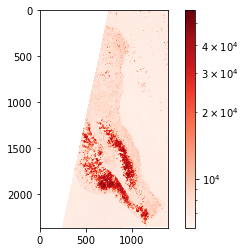

In [87]:
# Use a log scale


plt.imshow(out_image[0], cmap='Reds', norm=LogNorm())
plt.colorbar()

In [88]:
# Use the highest resolution (15m pan band)
# NOTE: should rename band to 'red' or '4'
# NOTE: strange the Landsat is UTM *north* crs, sentinel2 is UTM *south*
item = items[0]
band = 'pan'
url = item.asset(band)['href']
print(url)
with env:
    with rasterio.open(url) as src:
        width = src.width
        blockx = src.profile['blockxsize']
        blocky = src.profile['blockysize']
        #print(src.profile)
        xchunk = int(width/blockx)*blockx
        ychunk = blocky
        da = xr.open_rasterio(src, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

https://landsat-pds.s3.amazonaws.com/c1/L8/162/068/LC08_L1TP_162068_20131121_20170428_01_T1/LC08_L1TP_162068_20131121_20170428_01_T1_B8.TIF


<xarray.DataArray (band: 1, y: 15441, x: 15201)>
dask.array<shape=(1, 15441, 15201), dtype=uint16, chunksize=(1, 512, 14848)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -1.163e+06 -1.163e+06 ... -1.395e+06 -1.395e+06
  * x        (x) float64 2.991e+05 2.991e+05 2.991e+05 ... 5.271e+05 5.271e+05
Attributes:
    transform:   (15.0, 0.0, 299092.5, 0.0, -15.0, -1163392.5)
    crs:         +init=epsg:32638
    res:         (15.0, 15.0)
    is_tiled:    1
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [89]:
# NOTE: UTM coords, if we want to overlay other things we need to convert coords to WGS84 or WebMercator

crs = ccrs.UTM(zone='38N') 
img = da.hvplot.image(crs=crs, rasterize=True, width=700, height=500, cmap='reds', alpha=0.8, title=f'{item.id} ({band})') # , logz=True not working 
aoi = gfa.hvplot(geo=True, line_color='b', fill_color=None)
tiles * img * aoi

:DynamicMap   [band]
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [x,y]   (value)
      .Polygons.I :Polygons   [Longitude,Latitude]

In [90]:
# 48 PWC is our best tile
# Custom syntax (additional fields, query strings instead of query dict) 
properties =  ["sentinel:latitude_band=L",
               "sentinel:grid_square=MM",
               "eo:cloud_cover<10"] 
results = satsearch.Search.search(collection='sentinel-2-l1c', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % results.found())
items = results.items()

0 items


In [91]:
def browse_images(items):
    n = len(items)

    def view_image(i=0):
        item = items[i]
        print(f"id={item.id}\tdate={item.datetime}\tcloud%={item['eo:cloud_cover']}")
        display(Image(item.asset('thumbnail')['href']))
    
    interact(view_image, i=(0,n-1))

In [92]:
browse_images(items)

ValueError: value must be between min and max (min=0, value=-1, max=-1)

In [93]:
# Plot single band, full resolution
# NOTE: sentinel2 is "requester pays", meaning we need AWS credentials, 
# or we need to be in the same region as the data (eu-central-1) and then there are no charges for access
# https://forum.sentinel-hub.com/t/how-to-access-s-2-meta-data-in-aws-after-bucket-goes-to-requester-pays/328
item = items[5]
print(item.assets.keys())
print(item.assets_by_common_name.keys())
print(item.asset('thumbnail')['href'])
print(item.asset('red')['href'])

IndexError: list index out of range

In [94]:

env = rasterio.Env(AWSSession(region_name='eu-central-1', 
                              requester_pays=True),
                  )
url = 's3://sentinel-s2-l1c/tiles/38/L/MM/2016/5/2/0/B04.jp2'
with env:
    with rasterio.open(url) as src:
        print(src.profile)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32738), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 8700040.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


In [95]:
band = 'red'
url = item.asset(band)['href']
# NOTE: need a function to turn https url (href) to s3:
url = 's3://sentinel-s2-l1c/tiles/38/L/MM/2016/5/2/0/B04.jp2'

env = rasterio.Env(AWSSession(region_name='eu-central-1', 
                              requester_pays=True),
                  )

with env:
    with rasterio.open(url) as src:
        width = src.width
        blockx = src.profile['blockxsize']
        blocky = src.profile['blockysize']
        #print(src.profile)
        xchunk = int(width/blockx)*blockx
        ychunk = blocky
        da = xr.open_rasterio(src, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 1024, 10240)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 8.7e+06 8.7e+06 8.7e+06 ... 8.59e+06 8.59e+06 8.59e+06
  * x        (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
Attributes:
    transform:   (10.0, 0.0, 399960.0, 0.0, -10.0, 8700040.0)
    crs:         +init=epsg:32738
    res:         (10.0, 10.0)
    is_tiled:    1
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [ ]:
# NOTE: some sort of error happening here will need to investigate...

# NOTE: good example of all nans in area of interest
# These high-res images can take a while on local internet!
crs = ccrs.UTM(zone=38, southern_hemisphere=True) 
img = da.hvplot.image(crs=crs, rasterize=True, width=700, height=500, cmap='reds', alpha=0.8, title=f'{item.id} ({band})') # , logz=True not working 
aoi = gfa.hvplot(geo=True, line_color='b', fill_color=None)
tiles * img * aoi